
# Modelagem de um classificador binário de convenios  

Todos os convênios que não estavam na situação 'em execução' foram classificados entre insucesso e não-insucesso.  
Foram classifcados como insucesso os convênios cuja situação era 'Prestação de Contas Rejeitada', 'Inadimplente', 'Convênio Rescindido' os demais foram classificados com não-insucesso.

## 1. Importando as bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import pickle
import gc

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import classification_report, mean_squared_error

import nltk
_ = nltk.download('rslp', quiet=True)


## 2. Caregamento dos dados brutos

In [2]:
convenios = pd.read_csv('../data_files/csv_files/convenios.csv.gz', decimal=',', sep=';', compression='gzip', encoding='utf-8')
proponentes = pd.read_csv('../data_files/csv_files/proponentes.csv.gz', decimal=',', sep=';', compression='gzip', encoding='utf-8')
emendas_convenios = pd.read_csv('../data_files/csv_files/emendas_convenios.csv.gz', decimal=',', sep=';', compression='gzip', encoding='utf-8')
emendas = pd.read_csv('../data_files/csv_files/emendas.csv.gz', decimal=',', sep=';', compression='gzip', encoding='utf-8')
movimento = pd.read_csv('../data_files/csv_files/movimento.csv.gz', decimal=',', sep=';', compression='gzip', encoding='utf-8')
fornecedores = pd.read_csv('../data_files/csv_files/fornecedores.csv.gz', decimal=',', sep=';', compression='gzip', encoding='utf-8')


## 3. Seleção dos convênios
> Apenas convenios que não estão em execução e cujo ano do fim da vigência é 2017 ou posterior. 
>
> Foram considerados como insucesso convênios cuja situação é 'Prestação de Contas Rejeitada', 'Inadimplente' ou 'Convênio Rescindido'.

In [3]:
convenios = convenios[(convenios['DIA_FIM_VIGENC_CONV'].astype('datetime64[ns]').dt.year >=2017) & (convenios['DIA_PUBL_CONV'].notna())].copy()
convenios = convenios[convenios['SIT_CONVENIO'].str.upper()!='EM EXECUÇÃO']
convenios['INSUCESSO'] = 0
convenios.loc[convenios['SIT_CONVENIO'].isin(['Prestação de Contas Rejeitada', 'Inadimplente', 'Convênio Rescindido']), 'INSUCESSO'] = 1


## 4. Definição da classe TextTransformer  
> Esta classe realiza a o agrupamento (clustering) de textos com o algorítimo K-Means.  
> A finalidade aqui é representar os textos da coluna 'OBJETO_PROPOSTA' em classes designadas por números inteiros.

In [4]:
class TextTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_clusters=5, stop_words=[], accented=[]):
        
        self.__n_clusters__ = n_clusters
        self.__stop_words__ = stop_words
        self.__accented__ = accented
        self.labels_ = None
        self.__vectorizer__ = TfidfVectorizer(use_idf=True)
        self.__clusterer__ = KMeans(n_clusters=self.__n_clusters__, random_state=0)
    
    def fit(self, X):
        
        X = self.__preprocessing__(X)
        X = self.__vectorizer__.fit_transform(X)
        self.__clusterer__ = self.__clusterer__.fit(X)
        self.labels_ = self.__clusterer__.labels_
        return self

    def fit_transform(self, X):
        
        X = self.__preprocessing__(X)
        X = self.__vectorizer__.fit_transform(X)
        X = self.__clusterer__.fit_transform(X)
        self.labels_ = self.__clusterer__.labels_
        return X
    
    def fit_predict(self, X):
        
        X = self.__preprocessing__(X)
        X = self.__vectorizer__.fit_transform(X)
        y = self.__clusterer__.fit_predict(X)
        self.labels_ = self.__clusterer__.labels_
        return y
    
    def transform(self, X):        
        
        X = self.__preprocessing__(X)
        X = self.__vectorizer__.transform(X)
        X = self.__clusterer__.transform(X)
        return X
                       
    def predict(self, X):
        
        return_unique = False
        if type(X)==str:
            X = [X]
            return_unique = True
        
        X = self.__preprocessing__(X)
        X = self.__vectorizer__.transform(X)
        y = self.__clusterer__.predict(X)
        y = y[0] if return_unique else y
        return y
    
    def __preprocessing__(self, X):
        
        X = [' '.join(self.__text_preprocessing__(t)) for t in X]
        return X
    
    def __stemming__(self, tokens):  
        
        stemmer = nltk.stem.RSLPStemmer()
        return [stemmer.stem(token) for token in tokens]

    def __remove_accents__(self, text):
        
        for idx in self.__accented__.index:
            text = text.replace(self.__accented__['char_acc'][idx], self.__accented__['char_norm'][idx]) 
        return text

    def __text_preprocessing__(self, text):
        
        text = text.lower()
        text = self.__remove_accents__(text)
        tokens = re.findall('[a-z]+', text)
        tokens = filter(lambda w: w is not None, map(lambda w: None if w in self.__stop_words__ or len(w)==1 else w , tokens))
        tokens = self.__stemming__(tokens)
        return tokens

## 5. Definição da função transform_dataset  
> Esta função realiza a conversão dos dados distribuídos nas tabelas (dataframes carregados) para um dataset (conjunto de dados).
> A finalidade aqui obter um conjunto de dados no formato apropriado para os algorítimos.

In [5]:
def transform_dataset(convenios, proponentes, emendas, emendas_convenios, fornecedores, movimento, ylabel=False, ylabel_name='INSUCESSO'):

    ibge = proponentes[['IDENTIF_PROPONENTE', 'CODIGO_IBGE']].copy()

    selected_columns = ['VL_REPASSE_CONV', 'VL_CONTRAPARTIDA_CONV', 'VALOR_EMENDA_CONVENIO',
           'OBJETO_PROPOSTA', 'COD_ORGAO', 'COD_ORGAO_SUP', 'NATUREZA_JURIDICA',
           'MODALIDADE', 'IDENTIF_PROPONENTE', 'COM_EMENDAS']

    features_columns = ['NR_CONVENIO', *selected_columns]
    if ylabel:
        features_columns += [ylabel_name]

    convenios_ = convenios[features_columns].copy()

    principais_parlamentares = get_principais_parlamentares(emendas=emendas, emendas_convenios=emendas_convenios, convenios_list=convenios_['NR_CONVENIO'].to_list())
    principais_fornecedores = get_principais_fornecedores(movimento=movimento, fornecedores=fornecedores, convenios_list=convenios_['NR_CONVENIO'].to_list())

    dataset = pd.merge(convenios_, ibge, how='inner', on=['IDENTIF_PROPONENTE'], left_index=False, right_index=False)

    dataset = pd.merge(dataset, principais_parlamentares, how='left', on=['NR_CONVENIO'], left_index=False, right_index=False)

    dataset = pd.merge(dataset, principais_fornecedores, how='left', on=['NR_CONVENIO'], left_index=False, right_index=False)

    dataset = dataset.fillna('NAO APLICAVEL')

    Xdtypes = {'VL_REPASSE_CONV': 'float64', 'VL_CONTRAPARTIDA_CONV': 'float64', 
               'VALOR_EMENDA_CONVENIO': 'float64', 'OBJETO_PROPOSTA': 'object', 
               'COD_ORGAO': 'int64', 'COD_ORGAO_SUP': 'int64', 'NATUREZA_JURIDICA': 'object', 
               'MODALIDADE': 'object', 'IDENTIF_PROPONENTE': 'int64', 'COM_EMENDAS': 'object',
               'CODIGO_IBGE': 'int64', 'PRINCIPAL_PARLAMENTAR': 'object', 'PRINCIPAL_FORNECEDOR': 'object'}

    return dataset.astype(Xdtypes)

In [6]:
def get_principais_parlamentares( emendas, emendas_convenios, convenios_list):

    convenios_repasses_emendas = emendas_convenios.loc[emendas_convenios['NR_CONVENIO'].isin(convenios_list)].copy()
    convenios_repasses_emendas['rank'] = convenios_repasses_emendas.groupby(by=['NR_CONVENIO'])['VALOR_REPASSE_EMENDA'].rank(ascending=False, method='min')
    convenios_repasses_emendas = convenios_repasses_emendas.loc[convenios_repasses_emendas['rank']==1, ['NR_CONVENIO', 'NR_EMENDA']]
    convenios_parlamentares = pd.merge(convenios_repasses_emendas, emendas, on=['NR_EMENDA'], left_index=False, right_index=False)
    convenios_parlamentares = convenios_parlamentares[['NR_CONVENIO', 'NOME_PARLAMENTAR']]
    convenios_parlamentares.columns = ['NR_CONVENIO', 'PRINCIPAL_PARLAMENTAR']
    convenios_parlamentares = convenios_parlamentares.groupby(by=['NR_CONVENIO']).max().reset_index()

    return convenios_parlamentares

In [7]:
def get_principais_fornecedores(movimento, fornecedores, convenios_list):

    movimento_exec = movimento.loc[movimento['NR_CONVENIO'].isin(convenios_list)].copy()
    movimento_exec = movimento_exec[movimento_exec['TIPO_MOV']=='P']
    convenios_fornecedores = movimento_exec[['NR_CONVENIO', 'FORNECEDOR_ID', 'VALOR_MOV']].groupby(by=['NR_CONVENIO', 'FORNECEDOR_ID']).sum().reset_index().copy()
    convenios_fornecedores['rank'] = convenios_fornecedores.groupby(by=['NR_CONVENIO'])['VALOR_MOV'].rank(ascending=False, method='min')
    convenios_fornecedores = convenios_fornecedores.loc[convenios_fornecedores['rank']==1, ['NR_CONVENIO', 'FORNECEDOR_ID']]
    convenios_fornecedores = pd.merge(convenios_fornecedores, fornecedores, on=['FORNECEDOR_ID'], left_index=False, right_index=False)
    convenios_fornecedores = convenios_fornecedores.sort_values(['NR_CONVENIO', 'IDENTIF_FORNECEDOR'], ascending=False)
    convenios_fornecedores = convenios_fornecedores[['NR_CONVENIO', 'IDENTIF_FORNECEDOR']]
    convenios_fornecedores.columns = ['NR_CONVENIO', 'PRINCIPAL_FORNECEDOR']
    convenios_fornecedores = convenios_fornecedores.groupby(by=['NR_CONVENIO']).max().reset_index()

    return convenios_fornecedores

## 6. Definição da função make_transformers  
> Esta função prepara um conjunto transformadores (transformers) para converter e normalizar os dados.   
> 1. Para os dados categóricos foi utilizado o codificador (encoder) 'OneHotEncoder'.  
> 2. Os dados contínuos foram normalizados com o 'PowerTransformer'.  
>
> A função make_transformers recebe um dataframe com os dados brutos e retorna um dicionário contendo todos os transformadores treinados.  

In [8]:
def make_transformers(X, stop_words_path, accented_path):

    accented = pd.read_csv(accented_path, compression='gzip', sep=';', encoding='utf-8')
    stop_words = pd.read_csv(stop_words_path, compression='gzip', encoding='utf-8', header=None)[0].tolist()
    data = X.copy()
    text_clusterer = TextTransformer(n_clusters=50, stop_words=stop_words, accented=accented).fit(data['OBJETO_PROPOSTA'])
    data['OBJETO_PROPOSTA'] = text_clusterer.predict(data['OBJETO_PROPOSTA'])
    data['OBJETO_PROPOSTA'] = data['OBJETO_PROPOSTA'].astype('int64')

    data_categorical_parlamentar = data.pop('PRINCIPAL_PARLAMENTAR').to_frame()
    data_categorical_fornecedor = data.pop('PRINCIPAL_FORNECEDOR').to_frame()

    data_categorical_object = data.select_dtypes(include=['object'])
    data_categorical_int = data.select_dtypes(include=['int64'])
    data_value = data.select_dtypes(include='float64')

    transformers = {}
    transformers['TEXT_CLUSTERER'] = text_clusterer
    transformers['VALUE'] = PowerTransformer().fit(data_value)
    transformers['CATEGORICAL_OBJECT'] = OneHotEncoder(handle_unknown='ignore').fit(data_categorical_object)
    transformers['CATEGORICAL_INT'] = OneHotEncoder(handle_unknown='infrequent_if_exist', max_categories=500).fit(data_categorical_int)
    transformers['CATEGORICAL_PARLAMENTAR'] = OneHotEncoder(handle_unknown='infrequent_if_exist', max_categories=500).fit(data_categorical_parlamentar)
    transformers['CATEGORICAL_FORNECEDOR'] = OneHotEncoder(handle_unknown='infrequent_if_exist', max_categories=500).fit(data_categorical_fornecedor)

    return transformers



## 7. Definição da função data_preparation  
> Esta função utiliza os transformadores (transformers) para converter e normalizar os dados.  
> A finalidade aqui é adequar os dados para serem utilizados nos algorítimos.  

In [9]:
def data_preparation(transformers, X):

    data = X.copy()
    data['OBJETO_PROPOSTA'] = transformers['TEXT_CLUSTERER'].predict(data['OBJETO_PROPOSTA'])
    data['OBJETO_PROPOSTA'] = data['OBJETO_PROPOSTA'].astype('int64')

    data_categorical_parlamentar = data.pop('PRINCIPAL_PARLAMENTAR').to_frame()
    data_categorical_fornecedor = data.pop('PRINCIPAL_FORNECEDOR').to_frame()

    data_categorical_object = data.select_dtypes(include=['object'])
    data_categorical_int = data.select_dtypes(include=['int64'])
    data_value = data.select_dtypes(include='float64')

    value_codes = transformers['VALUE'].transform(data_value)
    value_feature_names = transformers['VALUE'].feature_names_in_
    data_value = pd.DataFrame(value_codes, columns=value_feature_names).astype('float64')

    categorical_object_codes = transformers['CATEGORICAL_OBJECT'].transform(data_categorical_object).toarray()
    categorical_object_feature_names= transformers['CATEGORICAL_OBJECT'].get_feature_names_out()
    data_categorical_object = pd.DataFrame(categorical_object_codes, columns=categorical_object_feature_names).astype('float64')

    categorical_int_codes = transformers['CATEGORICAL_INT'].transform(data_categorical_int).toarray()
    categorical_int_feature_names= transformers['CATEGORICAL_INT'].get_feature_names_out()
    data_categorical_int = pd.DataFrame(categorical_int_codes, columns=categorical_int_feature_names).astype('float64')

    parlamentar_codes = transformers['CATEGORICAL_PARLAMENTAR'].transform(data_categorical_parlamentar).toarray()
    parlamentar_feature_names= transformers['CATEGORICAL_PARLAMENTAR'].get_feature_names_out()
    data_categorical_parlamentar = pd.DataFrame(parlamentar_codes, columns=parlamentar_feature_names).astype('float64')

    fornecedor_codes = transformers['CATEGORICAL_FORNECEDOR'].transform(data_categorical_fornecedor).toarray()
    fornecedor_feature_names= transformers['CATEGORICAL_FORNECEDOR'].get_feature_names_out()
    data_categorical_fornecedor = pd.DataFrame(fornecedor_codes, columns=fornecedor_feature_names).astype('float64')

    return pd.concat([data_value, data_categorical_object, data_categorical_int,
                      data_categorical_parlamentar, data_categorical_fornecedor], axis=1, sort=False)

## 8. Definição da função make_train_test_base  
> Esta função divide os dados originais em duas partes: uma para treino e outra para testes (avaliação).  
> A finalidade aqui é deixar essas bases disponíveis para os procedimwentos de treino e avaliação.  
> Esta função também se encarrega da conversão da coluna 'OBJETO_PROPOSTA' em agrupamentos (clusters), o que a transforma em uma coluna com dados categóricos passíveis de serem manipulados pelos algorítimos de normalização e classificação.  

In [10]:
def make_train_test_bases(**tables):
    
    assert not tables or set(tables.keys()) == {'convenios', 'proponentes', 'emendas', 'emendas_convenios', 
    'fornecedores', 'movimento'}, '''Named arguments, if provided, must be: convenios, emendas, emendas_convenios, fornecedores, movimento'''

    ylabel_name='INSUCESSO'
    print('transforming tables into dataset ... ', end='')
    data = transform_dataset(**tables, ylabel=True)
    data = data.drop(['NR_CONVENIO'], axis=1)
    print('ok')

    print('balancing ... ', end='')
    data = data.sample(frac=1).reset_index(drop=True)
    q0 = len(data[data[ylabel_name]==0])
    q1 = len(data[data[ylabel_name]==1])
    q = q0 if q0<q1 else q1

    X = pd.concat([data[data[ylabel_name]==0].iloc[0:q], data[data[ylabel_name]==1].iloc[0:q]], sort=False)
    y = X[[ylabel_name]]
    X = pd.concat([data[data[ylabel_name]==0].iloc[0:q], data[data[ylabel_name]==1].iloc[0:q]], sort=False)
    rest = data[~data.index.isin(X.index)]
    print('ok')

    print('spliting ... ', end='')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
    print('ok')

    print('saving train and test datasets ... ', end='')
    X_train.to_csv('./datasets/convenios_train.tsv.gz', compression='gzip', sep='\t', encoding='utf-8', index=False)
    X_test.to_csv('./datasets/convenios_test.tsv.gz', compression='gzip', sep='\t', encoding='utf-8', index=False)
    print('ok')

## 9. Definição da função get_tuned_estimator  
> Esta função realiza a seleção de hiperparâmetros (tuning).  
> A finalidade aqui é selecionar os melhores dentre um conjunto de hiperparâmetros escolhidos para o modelo informado.  
> Esta função retorna o melhor score obtido e os hiperparâmetros correspondentes.  

In [11]:
def get_tuned_estimator(X, y, estimator, param_dist, scoring='accuracy'):
    rand = GridSearchCV(estimator, param_dist, cv=10, refit=True, scoring=scoring)
    rand.fit(X, y['INSUCESSO'])

    return rand

## 10. Definição da função load_bases  
> Esta função é utilizada para a carga das bases de treino e de teste.  
> A finalidade aqui é propiciar um meio único e confiável de se realizar o carregamento das bases de treino e de teste.  
 

In [12]:
def load_bases(type='both', ylabel_name='INSUCESSO'):

    assert type in ['train', 'test', 'both']

    result = []
    if type.lower() in ['train', 'both']:
        train_base = pd.read_csv('./datasets/convenios_train.tsv.gz', compression='gzip', sep='\t', encoding='utf-8')
        X_train = train_base.drop([ylabel_name], axis=1)
        y_train = train_base[[ylabel_name]]
        result += [X_train, y_train]

    if type.lower() in ['test', 'both']:
        test_base = pd.read_csv('./datasets/convenios_test.tsv.gz', compression='gzip', sep='\t', encoding='utf-8')
        X_test = test_base.drop([ylabel_name], axis=1)
        y_test = test_base[[ylabel_name]]
        result += [X_test, y_test]

    return result

## 11. Criação das bases de treino e de teste
> Executado apenas quando se quer criar/recriar as bases de treino e teste a partir dos dados originais.  
 

In [13]:
make_train_test_bases(convenios=convenios, proponentes=proponentes, emendas=emendas, emendas_convenios=emendas_convenios, fornecedores=fornecedores, movimento=movimento)

transforming tables into dataset ... ok
balancing ... ok
spliting ... ok
saving train and test datasets ... ok


## 12. Liberação de memória com garbage collector
> Remoção de dataframes não mais necessários.  

In [14]:
del convenios
del proponentes
del emendas_convenios
del emendas
del movimento
del fornecedores 

_ = gc.collect()

## 13. Carregamento da base de treino e preparação dos dados 
> A função load_bases é utilizado para carregar a base de treino. Em seguida:  
> 1. A função make_transformers é utilizada para preparar os trasnformadores (normalizadores e codificadores). 
>
> 2. Também é instanciado um objeto PCA (principal component analysis) cuja finalidade é realizar a redução da dimensionalidade do modelo por meio do conceito de autovalores e autovetores.
>
> 3. Por fim, são aplicadas a preparação dos dados e a transformação PCA, de modo a se obter um cujunto de características (features) adquado e suficiente ao processo de teinamento do classificador.  
 

In [15]:
#train and test bases loading
X_train, y_train = load_bases(type='train')

#data preparation
transformers = make_transformers(X_train, stop_words_path='./datasets/stopwords.txt.gz', accented_path='./datasets/accented.txt.gz')
pca = PCA(n_components=700)

X_train = data_preparation(transformers, X_train)
pca.fit(X_train, y_train)
X_train = pca.transform(X_train)
print(f'Explained Variance Ratio ---> {round(sum(pca.explained_variance_ratio_)*100, 2)}%')

Explained Variance Ratio ---> 96.32%


## 14. Seleção do algorítimo e ajuste dos hiperparâmetros (tuning)
> Cada algorítimo candidato é treinado e avaliado com cross-validation por meio da função get_tuned_estimator, que utiliza o GridSearchCV. Neste caso o score a ser observado é o da precisão, já que se pretende que as predições de convênios com insucesso tenham mais probabilidade de estarem corretas (precision/precisão), mesmo que não se tenha bom desempenho em identificar todos convênios com insucesso (recall/revocação).  

In [16]:

estimators_list = [
    {
     'name': 'GNB',
     'estimator': GaussianNB(),
     'param_dist': {
             'var_smoothing': [1e-12, 1e-15, 1e-20]
              }

    },

    {
     'name': 'DTR',
     'estimator': DecisionTreeClassifier(),
     'param_dist': {
             'criterion': ['gini', 'entropy'],
              }

    },

    
    {
     'name': 'SVC',
     'estimator': SVC(),
     'param_dist': { 
                 'kernel': ['linear', 'rbf', 'sigmoid'],
                 'gamma':[2], 
                 'C': [1]
                 }
    },
    
    {
     'name': 'ADA',
     'estimator': AdaBoostClassifier(),
     'param_dist': {
             'n_estimators': [25, 50],
             'learning_rate': [1.0],
              }

    },
    
    {
     'name': 'MLP',
     'estimator': MLPClassifier(),
     'param_dist': {
                  'hidden_layer_sizes': [(10,), (20,), (30,), (10, 10), (10, 20), (10, 30)],
                  'alpha': [0.0001], 
                  'shuffle': [False],
                  'activation': ['relu'],
                  'max_iter': [2000]
                  }
    },
    
    {
     'name': 'RFC',
     'estimator': RandomForestClassifier(),
     'param_dist': {
                  'n_estimators': [25, 50],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [None]
                  }
    }
]


In [17]:
scoring = 'recall'
classifiers = {}
best_estimators = pd.DataFrame(data=[], columns=['estimator', 'params', scoring])

for est in estimators_list:
    print(f"estimator: {est['name']} --> ", end='')
    gs = get_tuned_estimator(X_train, y_train, estimator=est['estimator'], param_dist=est['param_dist'], scoring=scoring)
    params, score = gs.best_params_, gs.best_score_
    best_estimators = pd.concat([best_estimators, pd.DataFrame([[est['name'], str(params.copy()), score]], columns=best_estimators.columns)], axis=0, ignore_index=True, sort=False)
    classifiers[est['name']] = (gs.best_estimator_, params.copy())
    print(f'{scoring} = {score}')


estimator: GNB --> recall = 0.7322376237623762
estimator: DTR --> recall = 0.8
estimator: SVC --> recall = 0.9433366336633663
estimator: ADA --> recall = 0.8905445544554456
estimator: MLP --> recall = 0.8974950495049505
estimator: RFC --> recall = 0.9303762376237623


<AxesSubplot:xlabel='estimator'>

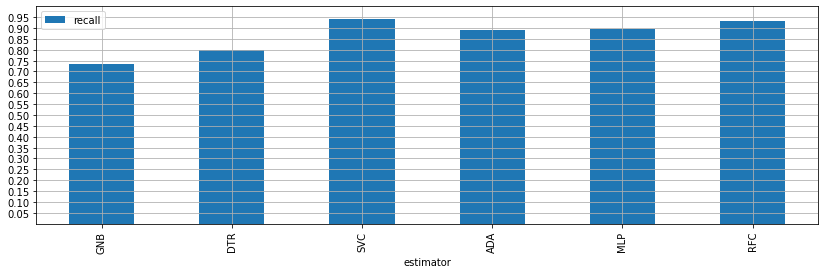

In [18]:
best_estimators.plot.bar(x='estimator', y=scoring, logy=False, ylim=[0, 1], grid=True, yticks=np.arange(0.05, 1, 0.05), figsize=(14, 4))

In [19]:
from IPython.display import HTML

HTML(best_estimators.to_html())

,estimator,params,recall
0,GNB,{'var_smoothing': 1e-12},0.732238
1,DTR,{'criterion': 'entropy'},0.800000
2,SVC,"{'C': 1, 'gamma': 2, 'kernel': 'linear'}",0.943337
3,ADA,"{'learning_rate': 1.0, 'n_estimators': 25}",0.890545
4,MLP,"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (30,), 'max_iter': 2000, 'shuffle': False}",0.897495
5,RFC,"{'criterion': 'entropy', 'max_features': None, 'n_estimators': 25}",0.930376



## 15. Avaliação dos classificadores selecionados  
> A finalidade aqui é comparar o desempenho dos classificadores configurados com os hiperparâmetros selecionados, na base de teste.  


In [20]:
#evaluation
X_test, y_test = load_bases(type='test')
X_test = data_preparation(transformers, X_test)
X_test = pca.transform(X_test)

for clf in classifiers:
    p = classifiers[clf][0].predict(X_test)
    print(f'Relatório de classificação para {clf}', '\n')
    print(classification_report(y_test['INSUCESSO'], p))
    print('\n')

Relatório de classificação para GNB 

              precision    recall  f1-score   support

           0       0.66      0.20      0.30       505
           1       0.51      0.89      0.64       467

    accuracy                           0.53       972
   macro avg       0.58      0.54      0.47       972
weighted avg       0.58      0.53      0.47       972



Relatório de classificação para DTR 

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       505
           1       0.82      0.82      0.82       467

    accuracy                           0.83       972
   macro avg       0.83      0.83      0.83       972
weighted avg       0.83      0.83      0.83       972



Relatório de classificação para SVC 

              precision    recall  f1-score   support

           0       0.94      0.87      0.91       505
           1       0.87      0.94      0.91       467

    accuracy                           0.91       972
   macro a

## 16. Escolha do classificador
> Escolha baseada nas métricas recall, precision, f1-score e accuracy.  

In [21]:
clf_name = 'RFC'
selected_classifier = classifiers[clf_name][0]
print(f'{clf_name} - Hiperparâmetros: {classifiers[clf_name][1]}')

RFC - Hiperparâmetros: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 25}


## 17. Armazenamento do modelo treinado em formato pickle
> A finalidade é que o modelo treinado possa ser utilizado em outra aplicação a partir do carregamento do arquivo pickle.  

In [22]:
def save_model(object_model, filename):
    with open(filename, 'wb') as fd:
        pickle.dump(object_model, fd)

In [23]:
class MLModel(object):
    def __init__(self, transformers, pca, clf):
        self.transformers = transformers
        self.pca = pca
        self.clf = selected_classifier
        
save_model(MLModel(transformers, pca, clf), './trained_model/model.pickle')